# **Trial 1**
- **Models to train:** Lightgbm - Histgradienboodting - Catboost - Extratrees - Bagging

- **to know:**

  - in p95(percentile 95) add negative values too
  - Train with 2022, want to predict 2023 full
  

In [ ]:
!pip install ta
!pip install catboost
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import calendar
import numpy as np
#from google.colab import data_table
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import ta
from scipy.stats import mstats
from sklearn.metrics import make_scorer
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.stats.diagnostic as smd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression,SelectPercentile
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.feature_selection import RFE

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=caee0a90e54d3403a7bae51c85234971d1b1e90d4140dd08b1e4b5137f48f407
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.9 MB/s eta 0:00:00


# Global functions-code-util



In [ ]:
#features for all models - use in flask with no changes
selected_feature_names = [
        'topWick',
        'body',
        'bottomWick',
        'spread',
        'hour',
        'day',
        'month',
        'body_3',
        'body_5',
        'body_20',
        'ticks_2',
        'ticks_4',
        'ticks_5',
        'ticks_15',
        'ticks_60',
        'spread_5',
        'spread_log',
        'body_log',
        'ticks_log',
        'spread_sqrt',
        'body_sqrt',
]

In [ ]:
#times for lags
one_min = -60
two_min = -120
three_min = -180
four_min = -240
five_min = -300
ten_min = -600
fifteen_min = -900
twenty_min = -1200
twentyfive_min = -1500
thirty_min = -1800
fourty_min = -2400
sixty_min = -3600

# 2022 Dataset

In [ ]:
df_full_2022 = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/data/ExportedSecBarData 2022.csv',delimiter=";",header=None)
print(df_full_2022.shape)

(11670861, 11)


In [ ]:
df_full_2022.rename(columns={0: "timestamp_column", 1: "open", 2: "high", 3: "low", 4: "close", 5: "ticks", 6: "spread", 7: "direction", 8: "topWick", 9: "body",10: "bottomWick"}, inplace=True)
print(df_full_2022.shape)

(11670861, 11)


In [ ]:
df_full_2022.iloc[:, [0]] = pd.to_datetime(df_full_2022['timestamp_column'])

<ipython-input-6-1ccb3ad8f5c7>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_full_2022.iloc[:, [0]] = pd.to_datetime(df_full_2022['timestamp_column'])


In [ ]:
#logs
df_full_2022['close_log'] = np.log(df_full_2022['close'])
df_full_2022['open_log'] = np.log(df_full_2022['open'])

In [ ]:
#add Y_5 to 2022 dataset
df_full_2022['Y_5_log_1'] = (df_full_2022['close_log']*10000).shift(-300) - (df_full_2022['open_log']*10000)
df_full_2022['Y_5'] = (df_full_2022['close']*10000).shift(-300) - (df_full_2022['open']*10000)

# 2023 Dataset

In [ ]:
df_full_2023 = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Merged_Data.csv',
                      usecols=['datetime','open','high','low','close','ticks','spread','direction','topWick','body','bottomWick','Y_5'])

In [ ]:
df_full_2023.rename(columns={"datetime": "timestamp_column"}, inplace=True)

In [ ]:
df_full_2023.iloc[:, [0]] = pd.to_datetime(df_full_2023['timestamp_column'])

<ipython-input-11-fe6e3f81a00e>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_full_2023.iloc[:, [0]] = pd.to_datetime(df_full_2023['timestamp_column'])


In [ ]:
#logs
df_full_2023['close_log'] = np.log(df_full_2023['close'])
df_full_2023['open_log'] = np.log(df_full_2023['open'])

In [ ]:
df_full_2023['Y_5_log_1'] = (df_full_2023['close_log']*10000).shift(-300) - (df_full_2023['open_log']*10000)

# Concat 2022-2023

In [ ]:
# prompt: iloc specific features in df_full
df_2022 = df_full_2022.iloc[:, [0,1,2,3,4,5,6,8,9,10,13,14]]
print(df_2022.shape)

(11670861, 12)


In [ ]:
df_2023 = df_full_2023.iloc[:, [0,7,8,9,10,5,6,2,3,4,14,11]]
print(df_2023.shape)

(9811696, 12)


In [ ]:
# prompt: concat def_2022 and df_2023
df_22_23_concat = pd.concat([df_2022, df_2023])
print(df_22_23_concat.shape)

(21482557, 12)


# Full - DataBase

In [ ]:
df_22_23 = df_22_23_concat.dropna()

In [ ]:
#df_22_23.iloc[:, [0]] = pd.to_datetime(df_22_23['timestamp_column'])

In [ ]:
print('Full Data No missing values',df_22_23.shape)

Full Data No missing values (21481957, 12)


# DataBase NS Test
- data base only for test final models

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/monobot/data/TestData_202312_202401.csv',low_memory=False,delimiter=';',header=None)
print(test_data.shape)

(812632, 11)


In [ ]:
#rename columns
test_data.rename(columns={0: "timestamp_column", 1: "open", 2: "high", 3: "low", 4: "close", 5: "ticks", 6: "spread", 7: "direction", 8: "topWick", 9: "body",10: "bottomWick"}, inplace=True)
print(test_data.head(5))

      timestamp_column     open     high      low    close  ticks  spread  \
0  2023.12.21 16:40:08  1.09966  1.09969  1.09966  1.09966      7    12.0   
1  2023.12.21 16:40:09  1.09965  1.09970  1.09965  1.09970      6    10.0   
2  2023.12.21 16:40:10  1.09969  1.09969  1.09967  1.09967      2     2.0   
3  2023.12.21 16:40:11  1.09966  1.09966  1.09965  1.09965      2     4.0   
4  2023.12.21 16:40:12  1.09964  1.09966  1.09962  1.09966      6     8.0   

  direction  topWick  body  bottomWick  
0       'N'        2     0           0  
1       'U'        0     4           0  
2       'D'        0     2           0  
3       'D'        0     1           0  
4       'U'        0     2           1  


In [ ]:
#convert datatime to_datetime
test_data['timestamp_column'] = pd.to_datetime(test_data['timestamp_column'])

In [ ]:
#logs
test_data['close_log'] = np.log(test_data['close'])
test_data['open_log'] = np.log(test_data['open'])

In [ ]:
#target
test_data['Y_5_log_1'] = (test_data['close_log']*10000).shift(-300) - (test_data['open_log']*10000)

# ***Build Feat Test Data***

In [ ]:
# prompt: create new featires from datetime variable
test_data['hour'] = test_data['timestamp_column'].apply(lambda x: x.hour)
test_data['day'] = test_data['timestamp_column'].apply(lambda x: x.day)
test_data['month'] = test_data['timestamp_column'].apply(lambda x: x.month)

In [ ]:
# prompt: create lags from body, ticks and spead features
test_data['body_1'] = test_data['body'].shift(one_min)
test_data['body_2'] = test_data['body'].shift(two_min)
test_data['body_3'] = test_data['body'].shift(three_min)
test_data['body_4'] = test_data['body'].shift(four_min)
test_data['body_5'] = test_data['body'].shift(five_min)
test_data['body_10'] = test_data['body'].shift(ten_min)
test_data['body_15'] = test_data['body'].shift(fifteen_min)
test_data['body_20'] = test_data['body'].shift(twenty_min)
test_data['body_25'] = test_data['body'].shift(twentyfive_min)
test_data['body_30'] = test_data['body'].shift(thirty_min)
test_data['body_40'] = test_data['body'].shift(fourty_min)
test_data['body_60'] = test_data['body'].shift(sixty_min)

In [ ]:
#for ticks
test_data['ticks_1'] = test_data['ticks'].shift(one_min)
test_data['ticks_2'] = test_data['ticks'].shift(two_min)
test_data['ticks_3'] = test_data['ticks'].shift(three_min)
test_data['ticks_4'] = test_data['ticks'].shift(four_min)
test_data['ticks_5'] = test_data['ticks'].shift(five_min)
test_data['ticks_10'] = test_data['ticks'].shift(ten_min)
test_data['ticks_15'] = test_data['ticks'].shift(fifteen_min)
test_data['ticks_20'] = test_data['ticks'].shift(twenty_min)
test_data['ticks_25'] = test_data['ticks'].shift(twentyfive_min)
test_data['ticks_30'] = test_data['ticks'].shift(thirty_min)
test_data['ticks_40'] = test_data['ticks'].shift(fourty_min)
test_data['ticks_60'] = test_data['ticks'].shift(sixty_min)

In [ ]:
#for spread
test_data['spread_1'] = test_data['spread'].shift(one_min)
test_data['spread_2'] = test_data['spread'].shift(two_min)
test_data['spread_3'] = test_data['spread'].shift(three_min)
test_data['spread_4'] = test_data['spread'].shift(four_min)
test_data['spread_5'] = test_data['spread'].shift(five_min)
test_data['spread_10'] = test_data['spread'].shift(ten_min)
test_data['spread_15'] = test_data['spread'].shift(fifteen_min)
test_data['spread_20'] = test_data['spread'].shift(twenty_min)
test_data['spread_25'] = test_data['spread'].shift(twentyfive_min)
test_data['spread_30'] = test_data['spread'].shift(thirty_min)
test_data['spread_40'] = test_data['spread'].shift(fourty_min)
test_data['spread_60'] = test_data['spread'].shift(sixty_min)

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
test_data['spread_log'] = np.log(test_data['spread']+1)
test_data['body_log'] = np.log(test_data['body']+1)
test_data['ticks_log'] = np.log(test_data['ticks']+1)

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
test_data['spread_sqrt'] = np.sqrt(test_data['spread'])
test_data['body_sqrt'] = np.sqrt(test_data['body'])
test_data['ticks_sqrt'] = np.sqrt(test_data['ticks'])

In [ ]:
# prompt: Interaction Terms
test_data['spread_x_body'] = test_data['spread'] * test_data['body']
test_data['spread_x_ticks'] = test_data['spread'] * test_data['ticks']
test_data['body_x_ticks'] = test_data['body'] * test_data['ticks']

In [ ]:
#drop nan
test_data = test_data.dropna()
print(test_data.shape)

(809032, 62)


# Split data
- split before modeling to avoid data leackage

In [ ]:
#Train/Valid/Test
df_train_full = df_22_23[(df_22_23["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_22_23["timestamp_column"]<="2022-12-30 23:54:50")]
#df_valid_full = df_22_23[(df_22_23["timestamp_column"]>("2023-07-31 23:59:59")) & (df_22_23["timestamp_column"]<="2023-12-08 23:57:50")] # for valid

In [ ]:
print(df_train_full.timestamp_column.head(1))
print(df_train_full.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
11670560   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
print(f'Train size: {len(df_train_full)}')
#print(f'Valid size: {len(df_valid_full)}')
#print(f'Test size: {len(df_test_full)}')

Train size: 11670561


# Data Random Sample %

In [ ]:
# Convert the index to datetime, if it is not already
df_train_full.index = pd.to_datetime(df_train_full.index)

In [ ]:
# Sort the dataframe based on the timestamp
df_train_full = df_train_full.sort_index()

In [ ]:
# Set a seed for reproducibility (optional)
random_seed = 42
#pd.np.random.seed(random_seed)

In [ ]:
# Specify the desired sample percentage
sample_percentage = 0.2  # % of the data

In [ ]:
# Calculate the sample size as a percentage of the total number of rows
sample_size = int(len(df_train_full) * sample_percentage)

In [ ]:
# Take a random sample of the dataframe while preserving the time sequence
df_sample = df_train_full.sample(n=sample_size)
print(df_sample.shape)

(2334112, 12)


In [ ]:
# Sort the sampled dataframe based on the timestamp (optional, but recommended)
df_sample = df_sample.sort_index()

In [ ]:
print(df_sample.timestamp_column.head(1))
print(df_sample.timestamp_column.tail(1))

1970-01-01   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011670560   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# Calculate the desired sample size as a percentage of the total records
#sample_percentage = 100
#sample_size = int(len(df_train_full) * (sample_percentage / 100.0))

In [ ]:
# Perform random sampling
#sample_df = df_train_full.sample(n=sample_size, random_state=42)
#print(f'Sample size: {len(sample_df)}')

# Define original_df

In [ ]:
original_df = df_sample
#original_df = sample_df.copy()
print(f'Original size: {len(original_df)}')

Original size: 2334112


In [ ]:
print(original_df.timestamp_column.head(1))
print(original_df.timestamp_column.tail(1))

1970-01-01   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011670560   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


# 95 - percentile

In [ ]:
df_train_full.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5
count,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00,11670561.00
mean,1.05,1.05,1.05,1.05,2.75,12.32,0.10,1.03,0.09,-0.01,-0.02
std,0.05,0.05,0.05,0.05,2.07,23.63,0.46,2.11,0.45,5.43,5.64
min,0.95,0.95,0.95,0.95,1.00,0.00,0.00,0.00,0.00,-120.74,-135.30
50%,1.05,1.05,1.05,1.05,2.00,7.00,0.00,0.00,0.00,0.00,0.00
80%,1.10,1.10,1.10,1.10,4.00,17.00,0.00,2.00,0.00,3.65,3.80
90%,1.12,1.12,1.12,1.12,6.00,27.00,0.00,3.00,0.00,5.89,6.20
95%,1.13,1.13,1.13,1.13,7.00,38.00,1.00,5.00,1.00,8.09,8.40
max,1.15,1.15,1.15,1.15,59.00,2800.00,66.00,564.00,175.00,130.36,130.60


In [ ]:
percentile_95_df = df_train_full[(df_train_full['body'] >= 5) & (df_train_full['ticks'] >= 7) & (df_train_full['spread'] >= 38) &
                  (df_train_full['Y_5_log_1'] <= 50) & (df_train_full['Y_5_log_1'] >= -50)]
print(percentile_95_df.shape)

(124194, 12)


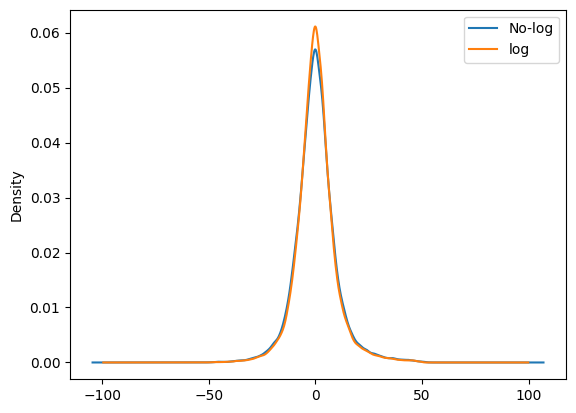

In [ ]:
percentile_95_df["Y_5"].plot.kde(label="No-log")
percentile_95_df["Y_5_log_1"].plot.kde(label="log")
plt.legend()

In [ ]:
percentile_95_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124194 entries, 1970-01-01 00:00:00.000001920 to 1970-01-01 00:00:00.011625487
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp_column  124194 non-null  datetime64[ns]
 1   open              124194 non-null  float64       
 2   high              124194 non-null  float64       
 3   low               124194 non-null  float64       
 4   close             124194 non-null  float64       
 5   ticks             124194 non-null  int64         
 6   spread            124194 non-null  float64       
 7   topWick           124194 non-null  int64         
 8   body              124194 non-null  int64         
 9   bottomWick        124194 non-null  int64         
 10  Y_5_log_1         124194 non-null  float64       
 11  Y_5               124194 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 12.

In [ ]:
print(percentile_95_df.timestamp_column.head(1))
print(percentile_95_df.timestamp_column.tail(1))

1970-01-01 00:00:00.000001920   2022-01-03 20:24:13
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011625487   2022-12-30 02:05:35
Name: timestamp_column, dtype: datetime64[ns]


# Data augmentation
- In this function, original_df represents your original time series dataset, and percentile_95_df represents the dataset containing values greater than the 95th percentile.

- You define the parameters augmentation_factor, which determines the proportion of augmented samples to generate, and noise_std, which controls the standard deviation of the added noise.

- Next, you call the augment_data function, passing in original_df, percentile_95_df, augmentation_factor, and noise_std as the function arguments. The function will return the augmented dataset, which you can store in the augmented_df variable.

- After obtaining the augmented dataset, you can use it for further preprocessing, model training, or any other analysis you need to perform.

Remember to adjust the parameters (augmentation_factor and noise_std) based on your specific requirements and dataset characteristics.

In [ ]:
### time sequence keep
def augment_data(original_df, percentile_95_df, augmentation_factor, noise_std):
    # Excluding the timestamp column
    columns_to_augment = original_df.columns[1:]

    # Sort the original dataframe based on the timestamp
    original_df = original_df.sort_values(by='timestamp_column')

    # Add original data points to augmented dataset
    augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True)

    # Compute the number of augmented samples to generate
    num_augmented_samples = int(len(original_df) * augmentation_factor)

    # Sort the percentile_95_df based on the timestamp
    percentile_95_df = percentile_95_df.sort_values(by='timestamp_column')

    # Randomly select indices from the 95th percentile dataset
    random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples)

    # Repeat the selected samples from the 95th percentile dataset
    augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True)

    # Add noise to the selected samples
    for column in columns_to_augment:
        noise = np.random.normal(0, noise_std, size=len(augmented_samples))
        augmented_samples[column] += noise

    # Add the augmented samples to the augmented dataset
    augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True)

    # Sort the augmented dataframe based on the timestamp
    augmented_df = augmented_df.sort_values(by='timestamp_column')

    return augmented_df

In [ ]:
#def augment_data(original_df, percentile_95_df, augmentation_factor, noise_std):
#    # Excluding the timestamp column
#    columns_to_augment = original_df.columns[1:]
#
#    # Add original data points to augmented dataset
#    augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True)
#
#    # Compute the number of augmented samples to generate
#    num_augmented_samples = int(len(original_df) * augmentation_factor)
#
#    # Randomly select indices from the 95th percentile dataset
#    random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples)
#
#    # Repeat the selected samples from the 95th percentile dataset
#    augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True)
#
#    # Add noise to the selected samples
#    for column in columns_to_augment:
#        noise = np.random.normal(0, noise_std, size=len(augmented_samples))
#        augmented_samples[column] += noise
#
#    # Add the augmented samples to the augmented dataset
#    augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True)
#
#    return augmented_df

## augmentation function explain

1. The augment_data function takes four parameters: original_df (the original dataframe), percentile_95_df (the 95th percentile dataframe), augmentation_factor (the factor by which the data will be augmented), and noise_std (the standard deviation of the noise to be added).

2. The function starts by excluding the timestamp column from the original dataframe to identify the columns that need augmentation.

3. The original dataframe (original_df) is then sorted based on the timestamp. This is done using sort_values method with the by parameter set to 'timestamp_column' (modify it according to your actual timestamp column name).

4. The original data points are added to the augmented dataset by concatenating the original dataframe with itself augmentation_factor + 1 times. This is achieved using pd.concat with the ignore_index parameter set to True.

5. The number of augmented samples to generate is computed by multiplying the length of the original dataframe by the augmentation_factor and taking the integer part.

6. The percentile_95_df is sorted based on the timestamp as well, similar to the step 3.

7. Random indices are selected from the percentile_95_df using np.random.choice, where the size of the selection is equal to num_augmented_samples. These indices determine which samples from the 95th percentile data will be augmented and added to the augmented dataset.

8. The selected samples from the percentile_95_df are repeated to match the number of augmented samples required. This is done by using percentile_95_df.loc[random_indices] and resetting the index using reset_index(drop=True).

9. Noise is added to the selected samples in each column to introduce variability. A random noise vector is generated using np.random.normal with mean 0 and noise_std as the standard deviation. The noise is then added to each column of the selected samples.

10. The augmented samples are added to the augmented dataset by concatenating them with the previously concatenated original dataframe. Again, pd.concat is used with ignore_index set to True.

11. Finally, the augmented dataframe is sorted based on the timestamp (timestamp_column) to ensure the time sequence is preserved properly.

12. The augmented dataframe is returned as the output of the function.

*This function generates augmented data by replicating and augmenting a subset of the 95th percentile data, while preserving the time sequence of the original and augmented dataframes.*

In [ ]:
print(original_df.shape)
print(percentile_95_df.shape)

(2334112, 12)
(124194, 12)


In [ ]:
# Define the augmentation factor and noise standard deviation
augmentation_factor = 0.5  # Set the desired augmentation factor
noise_std = 0.0  # Set the desired standard deviation of noise

**augmentation_factor**
- When augmentation_factor = 2.0, it means that the size of the augmented dataset will be twice the size of the original dataset. The value of augmentation_factor determines the proportion of augmented samples to generate relative to the original dataset.

- For example, if your original dataset has 100 samples and you set augmentation_factor = 2.0, the augmented dataset will have an additional 200 samples (twice the size of the original dataset).

- By adjusting the augmentation_factor, you can control the amount of augmentation and the resulting size of the augmented dataset. Higher values of augmentation_factor will generate more augmented samples, increasing the dataset's size, while lower values will generate fewer augmented samples.

**noise_std**
- When noise_std = 0.1, it means that Gaussian noise with a standard deviation of 0.1 will be added to the augmented samples. The value of noise_std controls the magnitude or amplitude of the added noise.

- In the augment_data function, we generate the Gaussian noise using np.random.normal(0, noise_std, len(augmented_sample)). Here, the mean of the Gaussian distribution is 0, and the standard deviation is noise_std.

- By adjusting the value of noise_std, you can control the amount of noise added to the augmented samples. A higher noise_std will result in a larger range of random noise values added to the data, introducing more variability. Conversely, a lower noise_std will result in smaller variations, generating less noisy samples.

- The purpose of adding noise is to simulate and capture the inherent uncertainty or variability present in the data. It can help make the model more robust by exposing it to different patterns and variations within the data.

Remember to choose an appropriate noise_std value depending on the characteristics of your dataset and the desired level of noise addition. Experimentation and fine-tuning may be needed to determine the suitable value for your specific task.

In [ ]:
# Calculate the size of augmented_df
original_rows = original_df.shape[0]
num_augmented_samples = int(original_rows * augmentation_factor)
augmented_rows = original_rows + num_augmented_samples

num_columns = original_df.shape[1]

final_size = (augmented_rows, num_columns)

print("Size of augmented_df: {} rows, {} columns".format(*final_size))

Size of augmented_df: 3501168 rows, 12 columns


In [ ]:
# Call the `augment_data` function with the excluded columns
#augmented_df = augment_data(original_array, percentile_95_array, augmentation_factor, noise_std)
augmented_df = augment_data(original_df, percentile_95_df, augmentation_factor, noise_std)

In [ ]:
augmented_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5
count,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00
mean,1.05,1.05,1.05,1.05,5.00,41.84,0.24,3.84,0.24,0.08,0.08
std,0.05,0.05,0.05,0.05,3.83,74.09,1.05,5.78,1.04,7.01,7.32
min,0.95,0.95,0.95,0.95,1.00,0.00,0.00,0.00,0.00,-119.76,-134.20
50%,1.05,1.05,1.05,1.05,4.00,14.00,0.00,1.00,0.00,0.00,0.00
80%,1.10,1.10,1.10,1.10,9.00,58.00,0.00,7.00,0.00,4.24,4.50
90%,1.12,1.12,1.12,1.12,11.00,82.00,1.00,10.00,1.00,7.14,7.50
95%,1.13,1.13,1.13,1.13,12.00,192.00,1.00,14.00,1.00,10.36,10.90
max,1.15,1.15,1.15,1.15,59.00,2800.00,66.00,459.00,93.00,124.62,124.90


In [ ]:
augmented_df.shape

(3501168, 12)

In [ ]:
print(augmented_df.timestamp_column.head(1))
print(augmented_df.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
2334111   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(augmented_df.groupby(augmented_df['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
1     144230
2     267783
3     507589
4     299818
5     404114
6     359501
7     268591
8     211014
9     255361
10    271994
11    275546
12    235627
Name: timestamp_column, dtype: int64


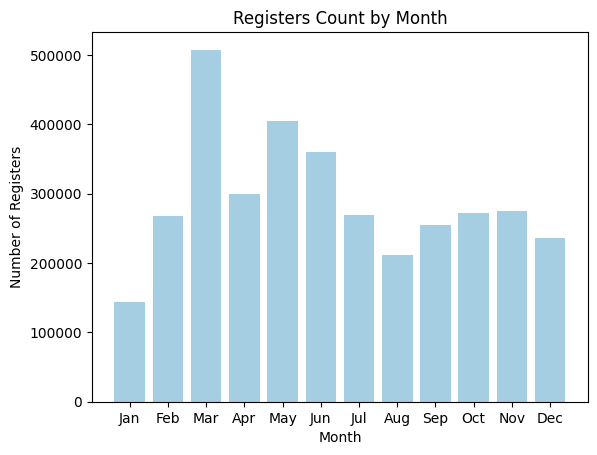

In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month and plot with month names
# Group data by month
monthly_counts = augmented_df.groupby(augmented_df['timestamp_column'].dt.month)['timestamp_column'].count()

# Get month names
month_names = calendar.month_abbr[1:]

# Create bar plot
plt.bar(month_names, monthly_counts)
plt.xlabel('Month')
plt.ylabel('Number of Registers')
plt.title('Registers Count by Month')
plt.show()

In [ ]:
augmented_df.to_csv('/content/drive/MyDrive/monobot/DeafReload/data/augmented_df_log_transf_time_order_ok.csv', index=False)

# Read augmented data

In [ ]:
augmented_df = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/data/augmented_df_log_transf_time_order_ok.csv')
print(augmented_df.shape)

(3501168, 12)


In [ ]:
#timestamp-column
augmented_df['timestamp_column'] = pd.to_datetime(augmented_df['timestamp_column'])

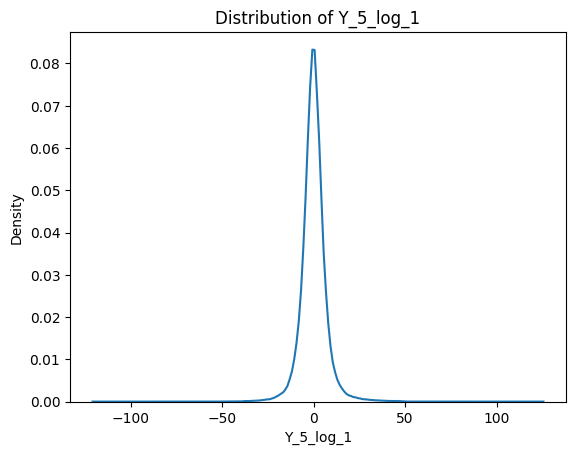

In [ ]:
plt.figure()
sns.kdeplot(augmented_df['Y_5_log_1'])
plt.title(f'Distribution of Y_5_log_1')
plt.show()

# Features Engeenireing AD

In [ ]:
# Specify the columns that contain NaN values
columns_to_convert = ['topWick','body',	'bottomWick','ticks','spread','open','high','low','close','Y_5_log_1']

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_df[column] = pd.to_numeric(augmented_df[column])

In [ ]:
augmented_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5
count,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00,3501168.00
mean,1.05,1.05,1.05,1.05,5.00,41.84,0.24,3.84,0.24,0.08,0.08
std,0.05,0.05,0.05,0.05,3.83,74.09,1.05,5.78,1.04,7.01,7.32
min,0.95,0.95,0.95,0.95,1.00,0.00,0.00,0.00,0.00,-119.76,-134.20
50%,1.05,1.05,1.05,1.05,4.00,14.00,0.00,1.00,0.00,0.00,0.00
80%,1.10,1.10,1.10,1.10,9.00,58.00,0.00,7.00,0.00,4.24,4.50
90%,1.12,1.12,1.12,1.12,11.00,82.00,1.00,10.00,1.00,7.14,7.50
95%,1.13,1.13,1.13,1.13,12.00,192.00,1.00,14.00,1.00,10.36,10.90
max,1.15,1.15,1.15,1.15,59.00,2800.00,66.00,459.00,93.00,124.62,124.90


# Create *data-variable* Dataset

In [ ]:
#drop nan if is any
augmented_df_nn = augmented_df.dropna()

In [ ]:
#create variable of data name to only chance one time
data_variable = augmented_df_nn.copy()

# Random Noises

In [ ]:
# 2 new noise variables from normal and uniform distribution
data_variable['noise_normal'] = np.random.normal(0, 1, size=data_variable.shape[0])
data_variable['noise_uniform'] = np.random.uniform(0, 1, size=data_variable.shape[0])

# Datetime features

In [ ]:
# prompt: create new featires from datetime variable
data_variable['hour'] = data_variable['timestamp_column'].apply(lambda x: x.hour)
data_variable['day'] = data_variable['timestamp_column'].apply(lambda x: x.day)
data_variable['month'] = data_variable['timestamp_column'].apply(lambda x: x.month)
#data['year'] = data['datetime'].apply(lambda x: x.year)

# Lags

## body lags

In [ ]:
# prompt: create lags from body, ticks and spead features
data_variable['body_1'] = data_variable['body'].shift(one_min)
data_variable['body_2'] = data_variable['body'].shift(two_min)
data_variable['body_3'] = data_variable['body'].shift(three_min)
data_variable['body_4'] = data_variable['body'].shift(four_min)
data_variable['body_5'] = data_variable['body'].shift(five_min)
data_variable['body_10'] = data_variable['body'].shift(ten_min)
data_variable['body_15'] = data_variable['body'].shift(fifteen_min)
data_variable['body_20'] = data_variable['body'].shift(twenty_min)
data_variable['body_25'] = data_variable['body'].shift(twentyfive_min)
data_variable['body_30'] = data_variable['body'].shift(thirty_min)
data_variable['body_40'] = data_variable['body'].shift(fourty_min)
data_variable['body_60'] = data_variable['body'].shift(sixty_min)

## ticks lags

In [ ]:
#for ticks
data_variable['ticks_1'] = data_variable['ticks'].shift(one_min)
data_variable['ticks_2'] = data_variable['ticks'].shift(two_min)
data_variable['ticks_3'] = data_variable['ticks'].shift(three_min)
data_variable['ticks_4'] = data_variable['ticks'].shift(four_min)
data_variable['ticks_5'] = data_variable['ticks'].shift(five_min)
data_variable['ticks_10'] = data_variable['ticks'].shift(ten_min)
data_variable['ticks_15'] = data_variable['ticks'].shift(fifteen_min)
data_variable['ticks_20'] = data_variable['ticks'].shift(twenty_min)
data_variable['ticks_25'] = data_variable['ticks'].shift(twentyfive_min)
data_variable['ticks_30'] = data_variable['ticks'].shift(thirty_min)
data_variable['ticks_40'] = data_variable['ticks'].shift(fourty_min)
data_variable['ticks_60'] = data_variable['ticks'].shift(sixty_min)

## spread lags

In [ ]:
#for spread
data_variable['spread_1'] = data_variable['spread'].shift(one_min)
data_variable['spread_2'] = data_variable['spread'].shift(two_min)
data_variable['spread_3'] = data_variable['spread'].shift(three_min)
data_variable['spread_4'] = data_variable['spread'].shift(four_min)
data_variable['spread_5'] = data_variable['spread'].shift(five_min)
data_variable['spread_10'] = data_variable['spread'].shift(ten_min)
data_variable['spread_15'] = data_variable['spread'].shift(fifteen_min)
data_variable['spread_20'] = data_variable['spread'].shift(twenty_min)
data_variable['spread_25'] = data_variable['spread'].shift(twentyfive_min)
data_variable['spread_30'] = data_variable['spread'].shift(thirty_min)
data_variable['spread_40'] = data_variable['spread'].shift(fourty_min)
data_variable['spread_60'] = data_variable['spread'].shift(sixty_min)

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
data_variable['spread_log'] = np.log(data_variable['spread']+1)
data_variable['body_log'] = np.log(data_variable['body']+1)
data_variable['ticks_log'] = np.log(data_variable['ticks']+1)

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
data_variable['spread_sqrt'] = np.sqrt(data_variable['spread'])
data_variable['body_sqrt'] = np.sqrt(data_variable['body'])
data_variable['ticks_sqrt'] = np.sqrt(data_variable['ticks'])

In [ ]:
# prompt: Interaction Terms
data_variable['spread_x_body'] = data_variable['spread'] * data_variable['body']
data_variable['spread_x_ticks'] = data_variable['spread'] * data_variable['ticks']
data_variable['body_x_ticks'] = data_variable['body'] * data_variable['ticks']

# Base for Model

# Voting Method 2 (PICK)

In [ ]:
print(data_variable.shape)

(3501168, 62)


In [ ]:
data_variable.columns.tolist()

['timestamp_column',
 'open',
 'high',
 'low',
 'close',
 'ticks',
 'spread',
 'topWick',
 'body',
 'bottomWick',
 'Y_5_log_1',
 'Y_5',
 'hour',
 'day',
 'month',
 'body_1',
 'body_2',
 'body_3',
 'body_4',
 'body_5',
 'body_10',
 'body_15',
 'body_20',
 'body_25',
 'body_30',
 'body_40',
 'body_60',
 'ticks_1',
 'ticks_2',
 'ticks_3',
 'ticks_4',
 'ticks_5',
 'ticks_10',
 'ticks_15',
 'ticks_20',
 'ticks_25',
 'ticks_30',
 'ticks_40',
 'ticks_60',
 'spread_1',
 'spread_2',
 'spread_3',
 'spread_4',
 'spread_5',
 'spread_10',
 'spread_15',
 'spread_20',
 'spread_25',
 'spread_30',
 'spread_40',
 'spread_60',
 'spread_log',
 'body_log',
 'ticks_log',
 'spread_sqrt',
 'body_sqrt',
 'ticks_sqrt',
 'spread_x_body',
 'spread_x_ticks',
 'body_x_ticks']

In [ ]:
df_sample = data_variable.dropna()

In [ ]:
X = df_sample.drop(['timestamp_column', 'Y_5','Y_5_log_2', 'high', 'low'], axis=1)
y = df_sample['Y_5_log_2']

In [ ]:
# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Create the feature selection method
#feature_selector = VarianceThreshold(threshold=0.01)
feature_selector = SelectPercentile(score_func=f_regression, percentile=30)

In [ ]:
# Create the individual regressor models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
decision_tree = DecisionTreeRegressor()

In [ ]:
# Create the voting regressor with different models
voting_regressor = VotingRegressor([('linear', linear_model), ('ridge', ridge_model), ('tree', decision_tree)])

In [ ]:
# Fit the feature selector on the standardized input data
X_selected = feature_selector.fit_transform(X_scaled, y)

In [ ]:
# Fit the voting regressor on the selected features
voting_regressor.fit(X_selected, y)

VotingRegressor(estimators=[('linear', LinearRegression()), ('ridge', Ridge()),
                            ('tree', DecisionTreeRegressor())])

In [ ]:
# Get the indices of the selected features
feature_indices = feature_selector.get_support(indices=True)

In [ ]:
# Get the selected feature names
selected_feature_names = X.columns[feature_indices]

In [ ]:
# Get the voting values of the selected features
voting_values = voting_regressor.predict(X_selected)

In [ ]:
# Determine the minimum length among the arrays
min_length = min(len(selected_feature_names), len(voting_values))

In [ ]:
# Create a new DataFrame with the selected feature names and voting values
results_df = pd.DataFrame({'Feature': selected_feature_names[:min_length], 'VotingValue': voting_values[:min_length]})

In [ ]:
# prompt: sort values
results_df.sort_values('VotingValue', ascending=False)

,Feature,VotingValue
8,ticks_20,0.000519
11,spread_5,0.000481
15,spread_x_body,0.000341
6,ticks_4,0.000270
3,body_5,0.000267
14,spread_sqrt,0.000248
4,body_10,0.000230
9,ticks_25,0.000152
12,spread_15,0.000135
16,spread_x_ticks,0.000117


<Axes: ylabel='Feature'>

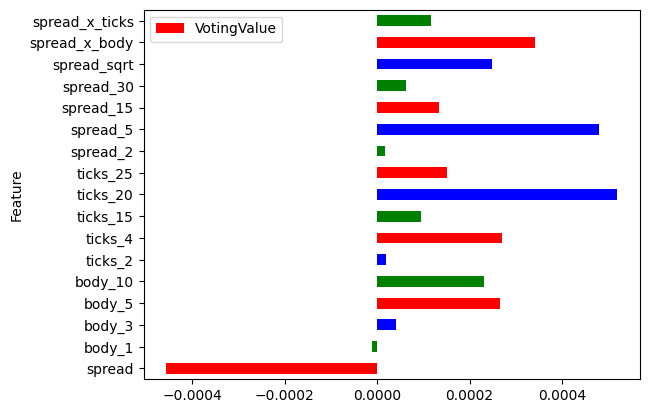

In [ ]:
results_df.plot.barh(x='Feature', y='VotingValue', color=['red', 'green', 'blue'])

# Models

#### **Model Methodology Explained:**

1. Outer Cross-Validation (TimeSeriesSplit): The dataset (X_train_cv_final and Y_train_cv) is split into training and validation sets using TimeSeriesSplit. In each iteration of the outer cross-validation loop, a different split of the data is used. The loop iterates 10 times (n_splits=10), meaning there will be 10 different training and validation sets.

2. Inner Cross-Validation (TimeSeriesSplit) and Hyperparameter Tuning: Inside the outer cross-validation loop, another TimeSeriesSplit is created to perform inner cross-validation for hyperparameter tuning. This inner cross-validation is done using a fixed train-validation split within each outer fold. In this case, n_splits=3 is used for the inner cross-validation, meaning three different splits of the training set are used.

3. LightGBM Regression Model: A LightGBM regressor (lgb.LGBMRegressor) is initialized as the base model for hyperparameter tuning.

3. RandomizedSearchCV: RandomizedSearchCV is used to perform hyperparameter tuning. It takes the initialized LightGBM regressor, a parameter grid (param_grid), and the inner cross-validation (inner_cv) as inputs. It performs random search over the parameter grid and evaluates the models using mean absolute percentage error ("neg_mean_absolute_percentage_error") as the scoring metric. Only one iteration (n_iter=1) is used in this example for the sake of brevity. The job is run in parallel using multiple cores (n_jobs=-1) and the verbosity level is set to 2 (verbose=2) for printing progress updates.

4. Best Model Selection: After the hyperparameter tuning is complete, the best model found during RandomizedSearchCV is extracted using lgb_random.best_estimator_.

5. Training Time: At the end of each iteration of the outer cross-validation loop, the training time of the current iteration is calculated and printed.

**Summary:**
*Nested cross-validation is performed to evaluate the performance of a LightGBM regression model with hyperparameter tuning. The outer loop splits the dataset into multiple training and validation sets and loops through them. In each outer loop iteration, an inner cross-validation loop is performed to tune the hyperparameters of the model using RandomizedSearchCV. The best model from hyperparameter tuning is selected and training time is tracked and printed. This process allows for a comprehensive evaluation of the model's performance and helps to select the best hyperparameters.*



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
# Import XGBoost
from xgboost import XGBRegressor
# Import CatBoost
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_absolute_percentage_error
from google.colab import data_table
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import time
import joblib
data_table.enable_dataframe_formatter()

In [ ]:
# to model optimization
def mean_directional_accuracy(y_true, y_pred):
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    directional_accuracy = np.mean(y_true_sign == y_pred_sign)
    return directional_accuracy

# Create a scoring function for Mean Directional Accuracy
scorer_mda = make_scorer(mean_directional_accuracy)

# Define the scoring metrics to be used
scoring_metrics = {
    "Neg Mean Absolute Error": "neg_mean_absolute_error",
    "Neg Mean Squared Error": "neg_mean_squared_error",
    "Explained Variance Score": "explained_variance",
    "Mean Directional Accuracy": scorer_mda
}

In [ ]:
df = data_variable.copy()
df.shape

(3501168, 62)

In [ ]:
#drop nan
df = df.dropna()

# Split data

In [ ]:
df_to_model = df[[
    'timestamp_column',
    'topWick',
    'body',
    'bottomWick',
    'spread',
    'hour',
    'day',
    'month',
    'body_3',
    'body_5',
    'body_20',
    'ticks_2',
    'ticks_4',
    'ticks_5',
    'ticks_15',
    'ticks_60',
    'spread_5',
    'spread_log',
    'body_log',
    'ticks_log',
    'spread_sqrt',
    'body_sqrt',
    'Y_5',
    'Y_5_log_1']]

In [ ]:
df_to_test = test_data[[
    'timestamp_column',
    'topWick',
    'body',
    'bottomWick',
    'spread',
    'hour',
    'day',
    'month',
    'body_3',
    'body_5',
    'body_20',
    'ticks_2',
    'ticks_4',
    'ticks_5',
    'ticks_15',
    'ticks_60',
    'spread_5',
    'spread_log',
    'body_log',
    'ticks_log',
    'spread_sqrt',
    'body_sqrt',
    'Y_5_log_1'
]]

In [ ]:
print(df_to_test.timestamp_column.head(1))
print(df_to_test.timestamp_column.tail(1))

0   2023-12-21 16:40:08
Name: timestamp_column, dtype: datetime64[ns]
809031   2024-01-24 21:26:17
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
print(df_to_model.timestamp_column.head(1))
print(df_to_model.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
3497567   2022-12-30 16:43:37
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
#Train/Valid/Test
df_train = df_to_model[(df_to_model["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_to_model["timestamp_column"]<="2022-09-30 23:55:00")]
df_valid = df_to_model[(df_to_model["timestamp_column"]>("2022-09-30 23:55:00")) & (df_to_model["timestamp_column"]<="2022-12-30 16:43:37")]
df_test = df_to_test[(df_to_test["timestamp_column"]>=("2023-12-21 16:40:08"))]

In [ ]:
#shape
#print(df_to_model.shape,"original data size")
print(df_train.shape,"train data size")
print(df_valid.shape,"valid data size")
print(df_test.shape, "test data size")

(2718001, 24) train data size
(779567, 24) valid data size
(809032, 23) test data size


In [ ]:
print(df_train.timestamp_column.head(1),"train data start")
print(df_train.timestamp_column.tail(1),"train data end")

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns] train data start
2718000   2022-09-30 23:55:00
Name: timestamp_column, dtype: datetime64[ns] train data end


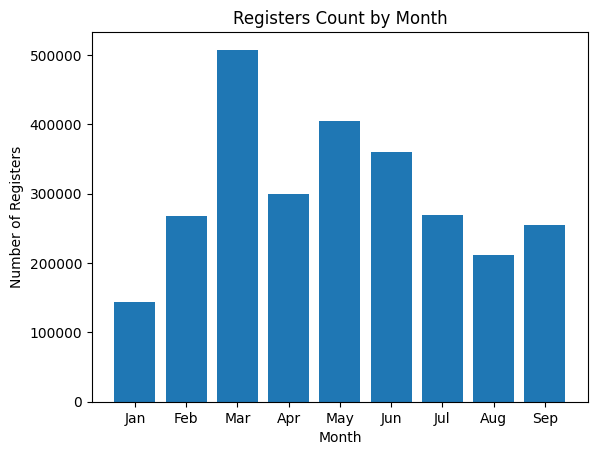

In [ ]:
monthly_counts = df_train.groupby(df_train['timestamp_column'].dt.month)['timestamp_column'].count()
# Get month names
month_names = calendar.month_abbr[1:10]

# Create bar plot
plt.bar(month_names, monthly_counts)
plt.xlabel('Month')
plt.ylabel('Number of Registers')
plt.title('Registers Count by Month')
plt.show()

In [ ]:
print(df_valid.timestamp_column.head(1),"valid data start")
print(df_valid.timestamp_column.tail(1),"valid data end")

2718001   2022-10-03 00:06:04
Name: timestamp_column, dtype: datetime64[ns] valid data start
3497567   2022-12-30 16:43:37
Name: timestamp_column, dtype: datetime64[ns] valid data end


In [ ]:
monthly_counts = df_valid.groupby(df_valid['timestamp_column'].dt.month)['timestamp_column'].count()

In [ ]:
monthly_counts

timestamp_column
10    271994
11    275546
12    232027
Name: timestamp_column, dtype: int64

In [ ]:
print(df_test.timestamp_column.head(1), "test data start")
print(df_test.timestamp_column.tail(1), "test data end")

0   2023-12-21 16:40:08
Name: timestamp_column, dtype: datetime64[ns] test data start
809031   2024-01-24 21:26:17
Name: timestamp_column, dtype: datetime64[ns] test data end


# Train-Validation-Y

In [ ]:
##Model configuration
Y_train_cv, X_train_cv = df_train.Y_5_log_1, df_train
Y_validation, X_validation = df_valid.Y_5_log_1, df_valid

In [ ]:
Xs = X_train_cv.columns.to_list()

In [ ]:
X_train_cv_final = df_train[Xs]
#inner_cv_groups = X_train_cv_final["date_time_1"]
X_train_cv_final.drop(["timestamp_column",'Y_5','Y_5_log_1'], axis=1, inplace=True)

In [ ]:
X_validation_final = X_validation[Xs]
#outer_cv_groups = X_validation_final["datetime"]
X_validation_final.drop(["timestamp_column",'Y_5','Y_5_log_1'], axis=1, inplace=True)

In [ ]:
print(X_train_cv_final.shape)
print(Y_train_cv.shape)

(2718001, 21)
(2718001,)


# ***1. XGBoost***

## Param Grid

In [ ]:
param_grid = {
    'learning_rate': [1.5],
    'max_depth': [12],
    'subsample': [0.6],
    'colsample_bytree': [0.8],
    'n_estimators': [100],
    'gamma': [0],
    'min_child_weight': [200],
    'reg_alpha': [0],
    'reg_lambda': [0, 0.1]
}

- learning_rate: Learning rate controls the step size at each boosting iteration. A smaller learning rate makes the model learning slower but can help prevent overfitting.

- max_depth: Maximum depth of a tree. A higher value can allow the model to capture more complex relationships, but deep trees may overfit.

- subsample: Subsample ratio of the training instances. It defines the proportion of samples used for training each tree. A lower value can prevent overfitting by introducing randomness.

- colsample_bytree: Subsample ratio of columns (features) when constructing each tree. Similar to subsample, it introduces randomness by selecting a subset of features for training each tree.

- n_estimators: Number of boosting rounds (trees) to build. A higher value can lead to a more powerful model but increases training time.

- gamma: Minimum loss reduction required for a further split. A higher value promotes more conservative tree pruning, reducing overfitting.

- min_child_weight: Minimum sum of instance weight needed in a child for it to be considered for splitting. Higher values prevent overfitting by adding more conservatism.

- reg_alpha: L1 regularization term on the weights. It encourages sparsity in the feature space and can help reduce overfitting.

- reg_lambda: L2 regularization term on the weights. It helps prevent overfitting by adding a penalty term to the loss function.

- scale_pos_weight: Control the balance of positive and negative weights in the dataset. It is useful for imbalanced classification tasks.

## Train XGBoost

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Set the random seed for reproducibility
random_seed = 42

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0
best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create XGBoost regressor
    xgb_model = XGBRegressor()

    # Perform RandomizedSearchCV with inner CV
    xgb_random = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state=random_seed
    )
    xgb_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_xgboost = xgb_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_xgboost.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_xgboost

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 11.168855905532837
Validation Set Evaluation:
Neg Mean Absolute Error: -6.919467741970411
Neg Mean Squared Error: -102.79030108149256
Explained Variance Score: -1.4126039974908262
Mean Directional Accuracy: 0.49417807211184694
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 21.042752265930176
Validation Set Evaluation:
Neg Mean Absolute Error: -6.798344613292062
Neg Mean Squared Error: -109.70573967608807
Explained Variance Score: -1.3905339004807722
Mean Directional Accuracy: 0.49725091979396613
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 34.07851982116699
Validation Set Evaluation:
Neg Mean Absolute Error: -7.0490542010211215
Neg Mean Squared Error: -138.56604962533652
Explained Variance Score: -1.1687698543133322
Mean Directional Accuracy: 0.5005253863134658
Best Model:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_byl

## Test XGBoost

In [ ]:
y_test_pred_xg = best_xgboost.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_xg=df_test.Y_5_log_1.to_frame().copy()
result_test_xg=df_test.copy()
result_test_xg["timestamp_column"]=df_test.timestamp_column
result_test_xg["set_type"]='test'

In [ ]:
result_test_xg["pred_test_xb"]=y_test_pred_xg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_xg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -3.0244313888247722
Neg Mean Squared Error: -17.653360062753215
Explained Variance Score: -0.2753503678437772
Mean Directional Accuracy: 0.5010061406718153


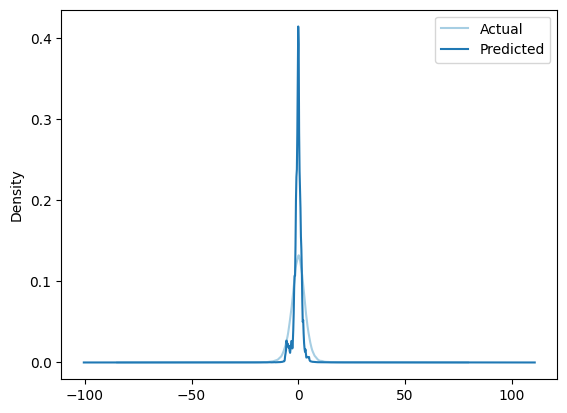

In [ ]:
result_test_xg["Y_5_log_1"].plot.kde(label="Actual")
result_test_xg["pred_test_xb"].plot.kde(label="Predicted")
plt.legend()

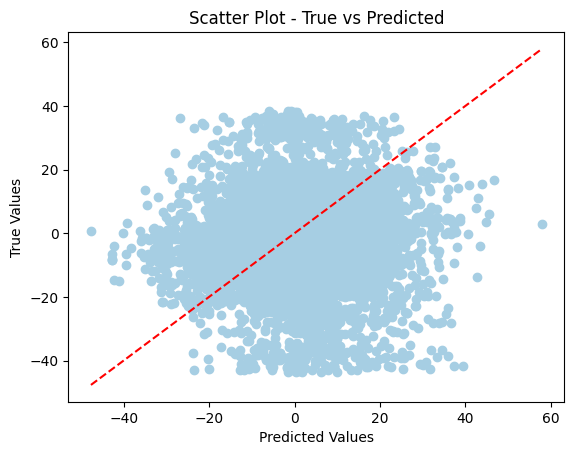

In [ ]:
# Assuming you have a dataframe called result_test_xg
true_label = result_test_xg['Y_5_log_1']
predicted_label = result_test_xg['pred_test_xb']

# Create the scatter plot
plt.scatter(predicted_label, true_label)

# Add a reference line with slope 1 for comparison
plt.plot([min(predicted_label), max(predicted_label)], [min(predicted_label), max(predicted_label)], color='red', linestyle='--')

# Add title and labels to the plot
plt.title('Scatter Plot - True vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

# Display the plot
plt.show()

In [ ]:
result_test_xg[["Y_5_log_1","pred_test_xb"]].head(20)

,Y_5_log_1,pred_test_xb
0,-0.636581,1.390460
1,-0.545643,-0.994009
2,-1.000332,1.863811
3,-0.636581,1.754616
4,-0.909430,2.859775
5,-1.546038,0.582335
6,-1.727987,0.963386
7,-1.909898,3.288305
8,-2.455584,3.271431
9,-2.455561,2.735392


# ***Save xb***

In [ ]:
filename = 'xg_model_log_target.sav'
pickle.dump(best_xgboost, open(filename, 'wb'))

# ***2. CatBoost***

In [ ]:
# Define the parameter grid for CatBoostRegressor
param_grid = {
    'learning_rate': [1.0],
    'depth': [12],
    'subsample': [0.8],
    'colsample_bylevel': [0.8],
    'n_estimators': [500],
    'l2_leaf_reg': [1]
}

## Train CatBoost

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Set the random seed for reproducibility
random_seed = 425

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0
best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create CatBoost regressor
    catboost_model = CatBoostRegressor()

    # Perform RandomizedSearchCV with inner CV
    catboost_random = RandomizedSearchCV(
        estimator=catboost_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state=random_seed
    )
    catboost_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_catboost = catboost_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_catboost.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_catboost

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0:	learn: 5.9034470	total: 181ms	remaining: 1m 30s
1:	learn: 5.7550789	total: 290ms	remaining: 1m 12s
2:	learn: 5.6155260	total: 394ms	remaining: 1m 5s
3:	learn: 5.5718230	total: 502ms	remaining: 1m 2s
4:	learn: 5.4889594	total: 604ms	remaining: 59.8s
5:	learn: 5.4062370	total: 704ms	remaining: 58s
6:	learn: 5.3644109	total: 812ms	remaining: 57.2s
7:	learn: 5.3305702	total: 923ms	remaining: 56.7s
8:	learn: 5.2877920	total: 1.03s	remaining: 56s
9:	learn: 5.2659897	total: 1.13s	remaining: 55.3s
10:	learn: 5.2321361	total: 1.23s	remaining: 54.7s
11:	learn: 5.1898608	total: 1.34s	remaining: 54.5s
12:	learn: 5.1436841	total: 1.44s	remaining: 53.9s
13:	learn: 5.1251629	total: 1.55s	remaining: 53.9s
14:	learn: 5.0784669	total: 1.66s	remaining: 53.5s
15:	learn: 5.0420407	total: 1.76s	remaining: 53.2s
16:	learn: 5.0138236	total: 1.86s	remaining: 52.9s
17:	learn: 4.9832811	total: 1.98s	remaining: 52.9s
18:	learn: 4.9659417	total: 2.08s	r

## Test CatBoost

In [ ]:
y_test_pred_cb = best_catboost.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_cb=df_test.Y_5_log_1.to_frame().copy()
result_test_cb=df_test.copy()
result_test_cb["timestamp_column"]=df_test.timestamp_column
result_test_cb["set_type"]='test'

In [ ]:
result_test_cb["pred_test_cb"]=y_test_pred_cb

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_cb))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -3.1043970836092463
Neg Mean Squared Error: -18.086034621722646
Explained Variance Score: -0.30932720307475026
Mean Directional Accuracy: 0.5006340911113528


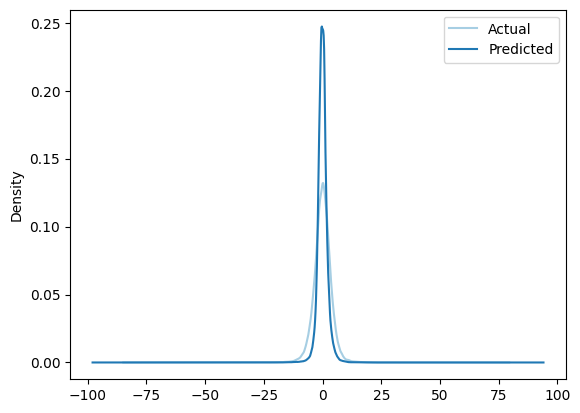

In [ ]:
result_test_cb["Y_5_log_1"].plot.kde(label="Actual")
result_test_cb["pred_test_cb"].plot.kde(label="Predicted")
plt.legend()

In [ ]:
result_test_cb[["Y_5_log_1","pred_test_cb"]].head(20)

,Y_5_log_1,pred_test_cb
0,-0.636581,-0.304786
1,-0.545643,-2.471739
2,-1.000332,-0.136881
3,-0.636581,-1.048803
4,-0.909430,-1.914300
5,-1.546038,2.396634
6,-1.727987,4.419356
7,-1.909898,-0.978989
8,-2.455584,0.382085
9,-2.455561,-2.475823


# *Save CatBoost*

In [ ]:
filename = 'cb_model_log_target.sav'
pickle.dump(best_catboost, open(filename, 'wb'))

# ***3. Lightgbm***

## Param Grid lg

In [ ]:
# Hyperparameter grid for LightGBM
param_grid = {
    'learning_rate': [0.5],   # step size for each iteration in boosting
    'n_estimators': [350],  # number of trees or boosting rounds
    'num_leaves': [200],  # maximum number of leaves in full trees
    'max_depth': [16],  # maximum tree depth for base learners
    'min_child_samples': [5],  # minimum number of data needed in a child (leaf), equivalent to min_data_in_leaf from your previous grid
    'max_bin': [200],  # max number of bins that feature values will be bucketed in
    'subsample': [1],  # fraction of samples to be used for fitting the individual base learners, corresponds to bagging_fraction
    'colsample_bytree': [1],  # fraction of columns to be randomly sampled for each tree
    'reg_alpha': [0],  # L1 regularization term on weights
    'reg_lambda': [0.1]  # L2 regularization term on weights
}

## Train lg

**If preserving the sign of the predicted values is important for your final prediction**, you can consider using a metric that is specifically designed to evaluate the direction or sign of the predictions. One such metric is the Mean Directional Accuracy (MDA) or Directional Accuracy (DA).

- Mean Directional Accuracy (MDA) or Directional Accuracy (DA):

- The MDA or DA measures the proportion of predictions that correctly capture the direction (sign) of the true values.
- It calculates the percentage of predictions that have the same sign (up or down) as the true values.
- MDA ranges from 0 to 1, with higher values indicating better performance in capturing the sign direction.

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

random_seed = 4578

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0
best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create LightGBM regressor
    lgb_model = LGBMRegressor(force_row_wise=True)

    # Perform RandomizedSearchCV with inner CV
    lgb_random = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state = random_seed
    )
    lgb_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_lightgbm  = lgb_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_lightgbm.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

  # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_lightgbm

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 679501, number of used features: 21
[LightGBM] [Info] Start training from score -0.147036
Training time: 17.03334879875183
Validation Set Evaluation:
Neg Mean Absolute Error: -5.441214152475185
Neg Mean Squared Error: -62.195414875949595
Explained Variance Score: -0.45960203925806153
Mean Directional Accuracy: 0.4992862398822664
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1359001, number of used features: 21
[LightGBM] [Info] Start training from score 0.016871
Training time: 25.96596598625183
Validation Set Evaluation:
Neg Mean Absolute Error: -5.454748332462583
Neg Mean Squared Error: -66.1747161803891
Explained Variance Score: -0.4425831720732285
Mean Directional Accuracy: 0.49730684326710817
Fitting 2 folds for each of 1 candidat

## Test Set lgm

In [ ]:
y_test_pred_lg = best_lightgbm.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_lg=df_test.Y_5_log_1.to_frame().copy()
result_test_lg=df_test.copy()
result_test_lg["timestamp_column"]=df_test.timestamp_column
result_test_lg["set_type"]='test'

In [ ]:
result_test_lg["pred_test_lg"]=y_test_pred_lg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_lg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.8355499216403333
Neg Mean Squared Error: -15.074876374356325
Explained Variance Score: -0.09129469017727398
Mean Directional Accuracy: 0.49284206310751616


<Axes: title={'center': 'predicho vs real'}>

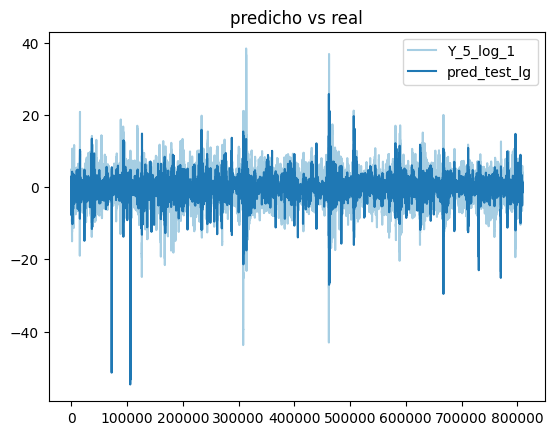

In [ ]:
result_test_lg[['Y_5_log_1','pred_test_lg']].plot(title="predicho vs real")

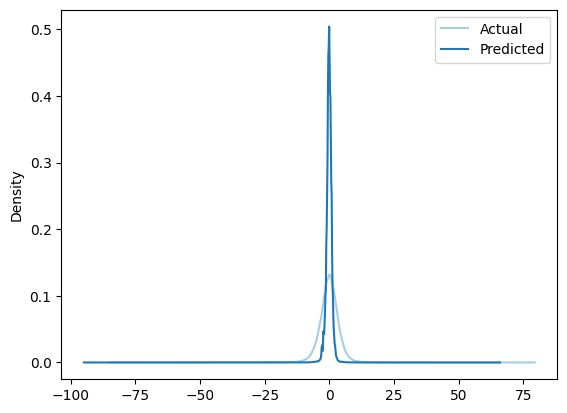

In [ ]:
result_test_lg["Y_5_log_1"].plot.kde(label="Actual")
result_test_lg["pred_test_lg"].plot.kde(label="Predicted")
plt.legend()

In [ ]:
result_test_lg[["Y_5_log_1","pred_test_lg"]].head(20)

,Y_5_log_1,pred_test_lg
0,-0.636581,0.043982
1,-0.545643,-0.187381
2,-1.000332,0.462876
3,-0.636581,-0.265536
4,-0.909430,0.440369
5,-1.546038,-1.525211
6,-1.727987,-1.586974
7,-1.909898,0.497174
8,-2.455584,-2.246523
9,-2.455561,0.531821


# ***Save lg***

In [ ]:
filename = 'lg_model_log_target.sav'
pickle.dump(best_lightgbm, open(filename, 'wb'))

# ***4. HistGradientBoosting***

## Param Grid hist

In [ ]:
#from sklearn.experimental import enable_hist_gradient_boosting  # Required for HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
param_grid = {
    "learning_rate": [0.2],  # Rate at which trees learn
    "max_iter": [600],  # Maximum number of iterations (trees)
    "max_depth": [16],  # Maximum depth of each tree
    'max_leaf_nodes': [450],  # Higher maximum leaf nodes increase model complexity
    "min_samples_leaf": [1],  # Minimum samples required to be at a leaf node
    "max_bins": [200],  # Maximum number of bins for histogram construction
    "l2_regularization": [1.8],  # L2 regularization strength
    "early_stopping": [True],  # Stop training if validation score doesn't improve for several iterations
    "random_state": [42]  # Set random seed for reproducibility
}

## Train hist

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

random_seed = 5678

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create HistGradientBoostingRegressor
    hist_gradient_model = HistGradientBoostingRegressor()

    # Perform RandomizedSearchCV with inner CV
    hist_gradient_random = RandomizedSearchCV(
        estimator=hist_gradient_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state = random_seed
    )
    hist_gradient_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_hist_gradient = hist_gradient_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_hist_gradient.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_hist_gradient

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 106.82452201843262
Validation Set Evaluation:
Neg Mean Absolute Error: -5.136489683082369
Neg Mean Squared Error: -55.15997937856766
Explained Variance Score: -0.29401910872969794
Mean Directional Accuracy: 0.4980485651214128
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 178.10346817970276
Validation Set Evaluation:
Neg Mean Absolute Error: -5.104897715847596
Neg Mean Squared Error: -55.93756242654632
Explained Variance Score: -0.2210667357507532
Mean Directional Accuracy: 0.4965401030169242
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 230.3365616798401
Validation Set Evaluation:
Neg Mean Absolute Error: -5.661315573827941
Neg Mean Squared Error: -77.26552860199874
Explained Variance Score: -0.21383465667426305
Mean Directional Accuracy: 0.5003473142016188
Best Model:
HistGradientBoostingRegressor(early_stopping=True, l2_regularization=1.8,
                

## Test Set hist

In [ ]:
y_test_pred_hist = best_hist_gradient.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_hist=df_test.Y_5_log_1.to_frame().copy()
result_test_hist=df_test.copy()
result_test_hist["timestamp_column"]=df_test.timestamp_column
result_test_hist["set_type"]='test'

In [ ]:
result_test_hist["pred_test_hist"] = y_test_pred_hist

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_hist))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.8542910214683954
Neg Mean Squared Error: -16.019760025394913
Explained Variance Score: -0.15937999611557285
Mean Directional Accuracy: 0.49756869938395515


<Axes: title={'center': 'predicho vs real'}>

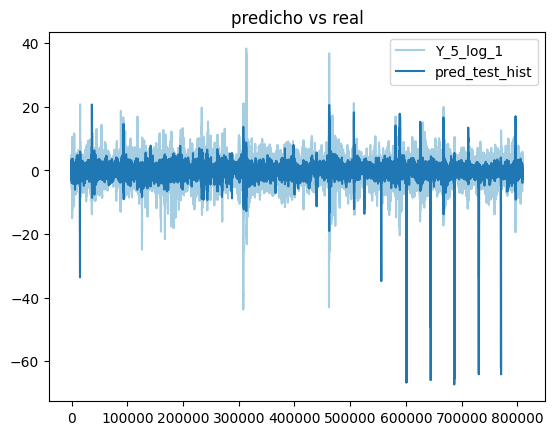

In [ ]:
result_test_hist[['Y_5_log_1','pred_test_hist']].plot(title="predicho vs real")

<Axes: ylabel='Density'>

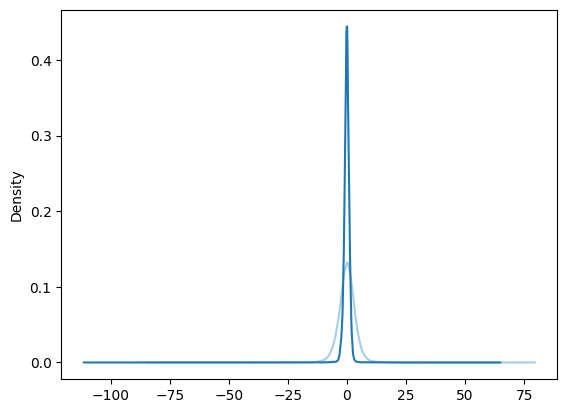

In [ ]:
result_test_hist["Y_5_log_1"].plot.kde(label="Actual")
result_test_hist["pred_test_hist"].plot.kde(label="pred")

In [ ]:
result_test_hist[["Y_5_log_1","pred_test_hist"]].head(20)

,Y_5_log_1,pred_test_hist
0,-0.636581,-2.013114
1,-0.545643,-0.428108
2,-1.000332,0.335625
3,-0.636581,-1.054676
4,-0.909430,-0.982299
5,-1.546038,2.273257
6,-1.727987,0.219751
7,-1.909898,0.174090
8,-2.455584,-0.339564
9,-2.455561,-1.728949


# ***Save hist***

In [ ]:
filename = 'hist_model_log_target.sav'
pickle.dump(best_hist_gradient, open(filename, 'wb'))

# ***5. SVR (NO CORRER)***

## Train svr

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Create SVR model
svr_model = SVR()

# Define the hyperparameter grid
param_grid = {
    "C": [1],
    "epsilon": [0.1]
}

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create SVR model
    svr_model = SVR()

    # Perform RandomizedSearchCV with inner CV
    svr_random = RandomizedSearchCV(
        estimator=svr_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    svr_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_svr = svr_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_svr.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_svr

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

## Test Set SVR

In [ ]:
y_test_pred_svr = best_svr.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_svr=df_test.Y_5_log_1.to_frame().copy()
result_test_svr=df_test.copy()
result_test_svr["timestamp_column"]=df_test.timestamp_column
result_test_svr["set_type"]='test'

In [ ]:
result_test_svr["pred_test_svr"] = y_test_pred_svr

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_svr)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_svr)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_svr)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_svr))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

In [ ]:
result_test_svr["Y_5_log_1"].plot.kde(label="Actual")
result_test_svr["pred_test_svr"].plot.kde(label="pred")

# *Save SVR*

In [ ]:
filename = 'svr_model_log_target.sav'
pickle.dump(best_svr, open(filename, 'wb'))

# ***6. KNeighborsRegressor (NO CORRER)***

## Train KN

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Create KNeighborsRegressor model
knn_model = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {
    "n_neighbors": [5],
    "weights": ["distance"],
    "p": [1]
}

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create KNeighborsRegressor model
    knn_model = KNeighborsRegressor()

    # Perform RandomizedSearchCV with inner CV
    knn_random = RandomizedSearchCV(
        estimator=knn_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    knn_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_knn = knn_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_knn.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_knn

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 2947.503560066223
Validation Set Evaluation:
Neg Mean Absolute Error: -3.8954817413535316
Neg Mean Squared Error: -29.926285405242517
Explained Variance Score: -0.17477177128698895
Mean Directional Accuracy: 0.5021985265779915
Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

## Test KN

In [ ]:
y_test_pred_knn = best_knn.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_knn=df_test.Y_5_log_1.to_frame().copy()
result_test_knn=df_test.copy()
result_test_knn["timestamp_column"]=df_test.timestamp_column
result_test_knn["set_type"]='test'

In [ ]:
result_test_knn["pred_test_knn"] = y_test_pred_knn

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_knn)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_knn)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_knn)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_knn))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

In [ ]:
result_test_knn["Y_5_log_1"].plot.kde(label="Actual")
result_test_knn["pred_test_knn"].plot.kde(label="pred")

# *Save KN*

In [ ]:
filename = 'knn_model_log_target.sav'
pickle.dump(best_knn, open(filename, 'wb'))

# ***7. AdaBoostRegressor (NO CORRER)***

## Train AdaBoostRegressor

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Create AdaBoostRegressor model
ada_model = AdaBoostRegressor()

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [800],
    "learning_rate": [1.9]
}

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create AdaBoostRegressor model
    ada_model = AdaBoostRegressor()

    # Perform RandomizedSearchCV with inner CV
    ada_random = RandomizedSearchCV(
        estimator=ada_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    ada_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_ada = ada_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_ada.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_ada

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 30.572205781936646
Validation Set Evaluation:
Neg Mean Absolute Error: -3.1467780455129715
Neg Mean Squared Error: -20.06917229833073
Explained Variance Score: -0.18701220807492236
Mean Directional Accuracy: 0.5000398380677399
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 124.6885998249054
Validation Set Evaluation:
Neg Mean Absolute Error: -5.196410498737474
Neg Mean Squared Error: -51.027572777876465
Explained Variance Score: -0.9358347948850432
Mean Directional Accuracy: 0.49791514112161234
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 150.42235851287842
Validation Set Evaluation:
Neg Mean Absolute Error: -5.419193692778039
Neg Mean Squared Error: -57.09021138256666
Explained Variance Score: -0.05144638309970029
Mean Directional Accuracy: 0.5129473720154648
Best Model:
AdaBoostRegressor(learning_rate=1.9, n_estimators=800)


## Test AdaBoost

In [ ]:
y_test_pred_ada = best_ada.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_ada=df_test.Y_5_log_1.to_frame().copy()
result_test_ada=df_test.copy()
result_test_ada["timestamp_column"]=df_test.timestamp_column
result_test_ada["set_type"]='test'

In [ ]:
result_test_ada["pred_test_ada"] = y_test_pred_ada

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_ada)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_ada)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_ada)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_ada))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -3.510967171134309
Neg Mean Squared Error: -24.641813133479882
Explained Variance Score: -0.0019088108184017738
Mean Directional Accuracy: 0.5042338459843864


<Axes: ylabel='Density'>

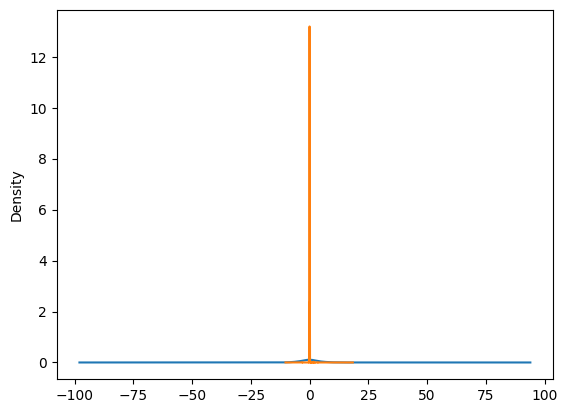

In [ ]:
result_test_ada["Y_5_log_1"].plot.kde(label="Actual")
result_test_ada["pred_test_ada"].plot.kde(label="pred")

In [ ]:
result_test_ada.head(15)

,timestamp_column,topWick,body,bottomWick,spread,hour,day,month,body_3,body_5,...,spread_5,spread_log,body_log,ticks_log,spread_sqrt,body_sqrt,Y_5,Y_5_log_1,set_type,pred_test_ada
26,2023-10-03 16:03:18,0.0,9.0,0.0,22.0,16,3,10,0.0,4.0,...,14.0,3.135494,2.302585,1.609438,4.690416,3.000000,4.5,4.298179,test,-0.103878
45,2023-10-10 12:05:25,0.0,0.0,0.0,5.0,12,10,10,0.0,4.0,...,24.0,1.791759,0.000000,0.693147,2.236068,0.000000,-3.2,-3.018270,test,0.026381
47,2023-10-27 13:13:36,0.0,0.0,0.0,5.0,13,27,10,2.0,1.0,...,10.0,1.791759,0.000000,0.693147,2.236068,0.000000,-8.8,-8.332071,test,-0.002102
54,2023-10-19 04:50:07,0.0,0.0,1.0,15.0,4,19,10,0.0,1.0,...,11.0,2.772589,0.000000,1.386294,3.872983,0.000000,1.9,1.803538,test,-0.002102
60,2023-10-20 17:07:28,0.0,5.0,0.0,20.0,17,20,10,0.0,1.0,...,9.0,3.044522,1.791759,1.609438,4.472136,2.236068,-10.9,-10.300755,test,-0.002102
63,2023-10-27 12:44:30,0.0,0.0,2.0,55.0,12,27,10,0.0,0.0,...,9.0,4.025352,0.000000,2.397895,7.416198,0.000000,2.4,2.272017,test,-0.002102
76,2023-10-05 06:25:55,0.0,0.0,1.0,15.0,6,5,10,0.0,0.0,...,4.0,2.772589,0.000000,1.386294,3.872983,0.000000,3.7,3.515389,test,0.026381
86,2023-10-12 15:34:39,2.0,2.0,0.0,60.0,15,12,10,1.0,0.0,...,25.0,4.110874,1.098612,2.484907,7.745967,1.414214,-5.3,-5.006731,test,0.026381
100,2023-10-04 18:43:11,1.0,0.0,0.0,26.0,18,4,10,2.0,1.0,...,16.0,3.295837,0.000000,1.791759,5.099020,0.000000,4.3,4.089221,test,0.141498
105,2023-10-11 16:05:22,0.0,2.0,1.0,38.0,16,11,10,4.0,1.0,...,9.0,3.663562,1.098612,2.079442,6.164414,1.414214,-2.4,-2.260866,test,0.026381


# *Save AdaBoost*

In [ ]:
filename = 'ada_model_log_target.sav'
pickle.dump(best_ada, open(filename, 'wb'))

# ***8. Bagging (NO CORRER)***

## Train Bagg

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Create BaggingRegressor model
bagging_model = BaggingRegressor()

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [30],
    "max_samples": [0.5],
    "max_features": [0.7]
}

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create BaggingRegressor model
    bagging_model = BaggingRegressor()

    # Perform RandomizedSearchCV with inner CV
    bagging_random = RandomizedSearchCV(
        estimator=bagging_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    bagging_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_bagging = bagging_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_bagging.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_bagging

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 66.73380780220032
Validation Set Evaluation:
Neg Mean Absolute Error: -3.687419075451407
Neg Mean Squared Error: -26.029860372769075
Explained Variance Score: -0.0029309830424819605
Mean Directional Accuracy: 0.5231679672077332
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 144.7202854156494
Validation Set Evaluation:
Neg Mean Absolute Error: -5.299996891894002
Neg Mean Squared Error: -52.67546639515056
Explained Variance Score: 0.0354252015830373
Mean Directional Accuracy: 0.5396128986465205
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 217.30854296684265
Validation Set Evaluation:
Neg Mean Absolute Error: -10.71911499721767
Neg Mean Squared Error: -139.33831418987234
Explained Variance Score: 0.15996321305132044
Mean Directional Accuracy: 0.6816594874433832
Best Model:
BaggingRegressor(max_features=0.7, max_samples=0.5, n_estimators=30)


## Test Bagging

In [ ]:
y_test_pred_bagg = best_bagging.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_bagg=df_test.Y_5_log_1.to_frame().copy()
result_test_bagg=df_test.copy()
result_test_bagg["timestamp_column"]=df_test.timestamp_column
result_test_bagg["set_type"]='test'

In [ ]:
result_test_bagg["pred_test_bagg"] = y_test_pred_bagg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_bagg)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_bagg)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_bagg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_bagg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.9341520424586123
Neg Mean Squared Error: -15.79920082810486
Explained Variance Score: -0.14345646176892068
Mean Directional Accuracy: 0.49636355545886934


<Axes: ylabel='Density'>

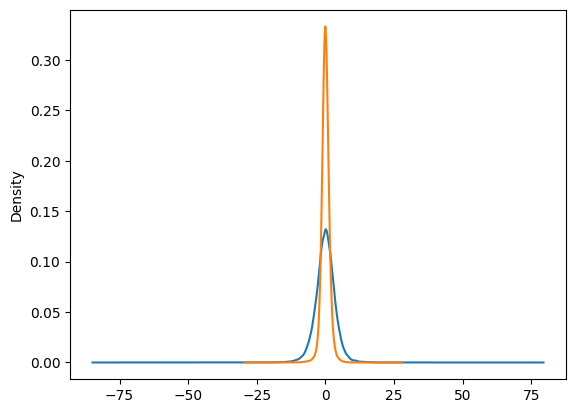

In [ ]:
result_test_bagg["Y_5_log_1"].plot.kde(label="Actual")
result_test_bagg["pred_test_bagg"].plot.kde(label="pred")

In [ ]:
result_test_bagg[["Y_5_log_1","pred_test_bagg"]].head(20)

,Y_5_log_1,pred_test_bagg
0,-0.636581,-1.293950
1,-0.545643,-6.525349
2,-1.000332,-2.304525
3,-0.636581,0.814239
4,-0.909430,-1.498098
5,-1.546038,-1.132899
6,-1.727987,2.475935
7,-1.909898,-5.775870
8,-2.455584,-9.605354
9,-2.455561,-5.076857


# *Save Bagging*

In [ ]:
filename = 'bagging_model_log_target.sav'
pickle.dump(best_bagging, open(filename, 'wb'))

# ***9. Extra-trees (NO CORRER)***

## Train Extra-trees

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Create ExtraTreesRegressor model
extra_trees_model = ExtraTreesRegressor()

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100],
    "max_depth": [32],
    "min_samples_split": [15],
    "min_samples_leaf": [4]
}

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create ExtraTreesRegressor model
    extra_trees_model = ExtraTreesRegressor()

    # Perform RandomizedSearchCV with inner CV
    extra_trees_random = RandomizedSearchCV(
        estimator=extra_trees_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    extra_trees_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_extra_trees = extra_trees_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_extra_trees.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_extra_trees

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

## Test Extra-trees

In [ ]:
y_test_pred_extr = best_extra_trees.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_extr=df_test.Y_5_log_1.to_frame().copy()
result_test_extr=df_test.copy()
result_test_extr["timestamp_column"]=df_test.timestamp_column
result_test_extr["set_type"]='test'

In [ ]:
result_test_extr["pred_test_extr"] = y_test_pred_extr

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_extr)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_extr)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_extr)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_extr))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.7914288023456706
Neg Mean Squared Error: -14.533612483288653
Explained Variance Score: -0.05209602414898362
Mean Directional Accuracy: 0.48966171919034107


<Axes: ylabel='Density'>

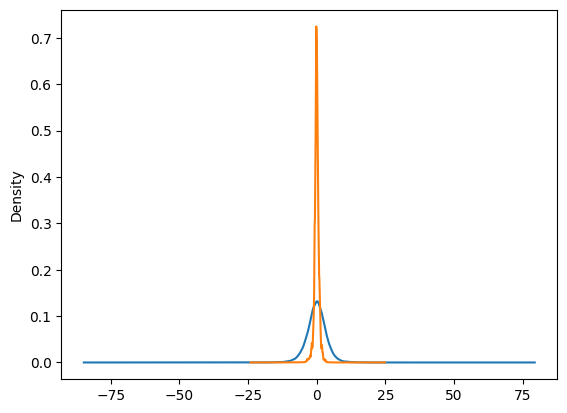

In [ ]:
result_test_extr["Y_5_log_1"].plot.kde(label="Actual")
result_test_extr["pred_test_extr"].plot.kde(label="pred")

In [ ]:
result_test_extr[["Y_5_log_1","pred_test_extr"]].head(20)

,Y_5_log_1,pred_test_extr
0,-0.636581,-0.571609
1,-0.545643,-1.122680
2,-1.000332,0.475065
3,-0.636581,0.540566
4,-0.909430,-0.328319
5,-1.546038,-0.601418
6,-1.727987,-0.314516
7,-1.909898,0.419172
8,-2.455584,0.475065
9,-2.455561,-0.222750


# *Save Extra-trees*

In [ ]:
filename = 'extree_model_log_target.sav'
pickle.dump(best_extra_trees, open(filename, 'wb'))

# ***10. Super Learner***

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [ ]:
filename_xg = 'xg_model_log_target.sav'
filename_cb = 'cb_model_log_target.sav'
filename_lg = 'lg_model_log_target.sav'
filename_lg95 = 'lg95_model_log_target.sav'
filename_hist = 'hist_model_log_target.sav'
filename_hist95 = 'hist_model95_log_target.sav'
filename_ext95 = 'extree95_model_log_target.sav'

In [ ]:
#load train models
best_xgboost = pickle.load(open(filename_xg, 'rb'))
best_catboost = pickle.load(open(filename_cb, 'rb'))
best_lightgbm = pickle.load(open(filename_lg, 'rb'))
best_lightgbm95 = pickle.load(open(filename_lg95, 'rb'))
best_hist_gradient = pickle.load(open(filename_hist, 'rb'))
best_hist_gradient95 = pickle.load(open(filename_hist95, 'rb'))
best_extra_trees95 = pickle.load(open(filename_ext95, 'rb'))

In [ ]:
selected_feature_names = [
        'topWick',
        'body',
        'bottomWick',
        'spread',
        'hour',
        'day',
        'month',
        'body_3',
        'body_5',
        'body_20',
        'ticks_2',
        'ticks_4',
        'ticks_5',
        'ticks_15',
        'ticks_60',
        'spread_5',
        'spread_log',
        'body_log',
        'ticks_log',
        'spread_sqrt',
        'body_sqrt',
]

## Define X,y

In [ ]:
# Calculate the desired sample size as a percentage of the total records
#sample_percentage = 100
#sample_size = int(len(df_to_model) * (sample_percentage / 100.0))

In [ ]:
# Perform random sampling
#sample_df = df_to_model.sample(n=sample_size, random_state=42)
#print(f'Sample size: {len(sample_df)}')

Sample size: 3497568


In [ ]:
#Train/Valid/Test
X_train = df_to_model[(df_to_model["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_to_model["timestamp_column"]<="2022-12-30 16:43:37")]
#df_test = df_to_model[(df_to_model["datetime"]>("2023-10-31 23:57:50")) & (df_to_model["datetime"]<="2023-12-08 23:29:17")]

In [ ]:
print(X_train.shape)
print(df_test.shape)

(3497568, 24)
(809032, 23)


In [ ]:
print(X_train.timestamp_column.head(1))
print(X_train.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
3497567   2022-12-30 16:43:37
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
X_train_ = X_train.dropna()
holdout = df_test.dropna()

In [ ]:
X_train_.columns

Index(['timestamp_column', 'topWick', 'body', 'bottomWick', 'spread', 'hour',
       'day', 'month', 'body_3', 'body_5', 'body_20', 'ticks_2', 'ticks_4',
       'ticks_5', 'ticks_15', 'ticks_60', 'spread_5', 'spread_log', 'body_log',
       'ticks_log', 'spread_sqrt', 'body_sqrt', 'Y_5', 'Y_5_log_1'],
      dtype='object')

In [ ]:
X = X_train_[selected_feature_names].values
print(X.shape)
y = X_train_['Y_5_log_1'].values
print(y.shape)

(3497568, 21)
(3497568,)


In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 1.09861229, 3.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.69314718, 2.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.69314718, 2.23606798,
        0.        ],
       ...,
       [0.        , 7.        , 0.        , ..., 2.07944154, 2.64575131,
        2.64575131],
       [0.        , 4.        , 0.        , ..., 1.38629436, 2.82842712,
        2.        ],
       [0.        , 2.        , 0.        , ..., 1.38629436, 2.23606798,
        1.41421356]])

## SL - Train Model

In [ ]:
# Step 1: Select a k-fold split of the training dataset
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Step 2: Select m base-models or model configurations
m = 2
base_models = [best_xgboost,best_catboost,best_lightgbm, best_hist_gradient,best_lightgbm95,best_hist_gradient95,best_extra_trees95]

In [ ]:
# Step 3: For each basemodel
oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions

for i, model in enumerate(base_models):
    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model

    # Step 3a: Evaluate using k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cloned_model = clone(model)  # Create a fresh clone of the model
        cloned_model.fit(X_train, y_train)  # Fit the model on the training set

        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold

    # Step 3b: Store all out-of-fold predictions
    oof_preds[:, i] = oof_model_preds

    # Step 3c: Fit the model on the full training dataset and store
    model.fit(X, y)

# Step 4: Fit a meta-model on the out-of-fold predictions
meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_preds, y)

0:	learn: 6.7234166	total: 437ms	remaining: 3m 38s
1:	learn: 6.5905295	total: 757ms	remaining: 3m 8s
2:	learn: 6.5397852	total: 1.06s	remaining: 2m 55s
3:	learn: 6.4633584	total: 1.36s	remaining: 2m 48s
4:	learn: 6.4180432	total: 1.65s	remaining: 2m 42s
5:	learn: 6.3676063	total: 1.94s	remaining: 2m 40s
6:	learn: 6.3234900	total: 2.24s	remaining: 2m 37s
7:	learn: 6.2974266	total: 2.55s	remaining: 2m 37s
8:	learn: 6.2465598	total: 2.87s	remaining: 2m 36s
9:	learn: 6.2122112	total: 3.17s	remaining: 2m 35s
10:	learn: 6.1801580	total: 3.48s	remaining: 2m 34s
11:	learn: 6.1488931	total: 3.77s	remaining: 2m 33s
12:	learn: 6.0893597	total: 4.08s	remaining: 2m 32s
13:	learn: 6.0563989	total: 4.41s	remaining: 2m 33s
14:	learn: 6.0371905	total: 4.71s	remaining: 2m 32s
15:	learn: 6.0180203	total: 5.01s	remaining: 2m 31s
16:	learn: 6.0076090	total: 5.32s	remaining: 2m 31s
17:	learn: 5.9896418	total: 5.63s	remaining: 2m 30s
18:	learn: 5.9741015	total: 5.9s	remaining: 2m 29s
19:	learn: 5.9532615	tot

Ridge()

In [ ]:
holdout_X = holdout[selected_feature_names].values

In [ ]:
holdout_X

array([[2.        , 0.        , 0.        , ..., 2.07944154, 3.46410162,
        0.        ],
       [0.        , 4.        , 0.        , ..., 1.94591015, 3.16227766,
        2.        ],
       [0.        , 2.        , 0.        , ..., 1.09861229, 1.41421356,
        1.41421356],
       ...,
       [0.        , 0.        , 1.        , ..., 1.38629436, 2.23606798,
        0.        ],
       [1.        , 0.        , 0.        , ..., 1.79175947, 2.44948974,
        0.        ],
       [0.        , 1.        , 0.        , ..., 1.09861229, 2.        ,
        1.        ]])

In [ ]:
# Step 5: Evaluate the model on a holdout dataset or use model to make predictions
holdout_preds = np.zeros((holdout_X.shape[0], len(base_models)))  # Store predictions on holdout dataset

for i, model in enumerate(base_models):
    holdout_preds[:, i] = model.predict(holdout_X)

final_preds = meta_model.predict(holdout_preds)

# Evaluate the performance or use final_preds for further analysis

In [ ]:
final_preds.shape

(809032,)

## Validations

In [ ]:
# Split the data into training, hold-out validation, and test sets
X_train, X_holdout, y_train, y_holdout = train_test_split(oof_preds, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# Train the meta-model on the training set
meta_model.fit(X_train, y_train)

# Tune hyperparameters using the hold-out validation set
val_preds = meta_model.predict(X_val)

# Evaluate the performance on the hold-out validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

# Make predictions on the test set
test_preds = meta_model.predict(X_test)

# Evaluate the performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

In [ ]:
val_rmse

4.095551520100469

In [ ]:
test_rmse

4.106792302543244

# ***Save meta-model***

In [ ]:
filename = 'meta_7_models_log_target.sav'
pickle.dump(meta_model, open(filename, 'wb'))

In [ ]:
# Step 6: Save the trained meta-model
#joblib.dump(meta_model, "meta_model.pkl")

In [ ]:
#predictions stored in separate variables
preds_base_model1 = result_test_xg['pred_test_xb'].values
preds_base_model2 = result_test_cb['pred_test_cb'].values
preds_base_model3 = result_test_lg['pred_test_lg'].values
preds_base_model4 = result_test_hist['pred_test_hist'].values
#preds_base_model5 = result_test_svr['pred_test_svr'].values
#preds_base_model6 = result_test_knn['pred_test_knn'].values
#preds_base_model7 = result_test_ada['pred_test_ada'].values
#preds_base_model8 = result_test_bagg['pred_test_bagg'].values
#preds_base_model9 = result_test_extr['pred_test_extr'].values

In [ ]:
preds_base_model3.shape

(809032,)

In [ ]:
# Create a dictionary to store the predictions
data = {
    'pred_model1': preds_base_model1,
    'pred_model2': preds_base_model2,
    'pred_model3': preds_base_model3,
    'pred_model4': preds_base_model4,
    #'pred_model5': preds_base_model5,
    #'pred_model6': preds_base_model6,
    #'pred_model7': preds_base_model7,
    #'pred_model8': preds_base_model8,
    #'pred_model9': preds_base_model9,
    'pred_meta_model': final_preds
}

In [ ]:
# Create a dataframe from the dictionary
predictions_df = pd.DataFrame(data)

In [ ]:
predictions_df.head(100)

,pred_model1,pred_model2,pred_model3,pred_model4,pred_meta_model
0,1.390460,-0.304786,0.043982,-2.013114,0.131867
1,-0.994009,-2.471739,-0.187381,-0.428108,-0.946374
2,1.863811,-0.136881,0.462876,0.335625,-0.939715
3,1.754616,-1.048803,-0.265536,-1.054676,-0.689878
4,2.859775,-1.914300,0.440369,-0.982299,-1.698105
...,...,...,...,...,...
95,0.624932,0.312021,-1.663238,-0.168416,-1.250500
96,1.981028,-0.808473,0.336584,-0.435076,-0.888308
97,1.846411,0.120422,0.497640,-0.051576,-1.691997
98,0.534561,-0.159806,0.313407,-0.214239,-0.488544


In [ ]:
# prompt: count negative vallues in each variable in predictions_df
print(predictions_df[predictions_df > 0].count(), "positive tendence")
print(predictions_df[predictions_df < 0].count(), "negative tendence")


pred_model1        378547
pred_model2        392886
pred_model3        385041
pred_model4        381290
pred_meta_model    414477
dtype: int64 positive tendence
pred_model1        430485
pred_model2        416146
pred_model3        423991
pred_model4        427742
pred_meta_model    394555
dtype: int64 negative tendence


# In Production

In [ ]:
import joblib

In [ ]:
# Load the saved models from the .pkl files
model1 = pickle.load(open('xg_model_log_target.sav', 'rb'))
model2 = pickle.load(open('cb_model_log_target.sav', 'rb'))
model3 = pickle.load(open('lg_model_log_target.sav', 'rb'))
model4 = pickle.load(open('hist_model_log_target.sav', 'rb'))
#model5 = pickle.load(open('svr_model_log_target.sav', 'rb'))
#model6 = pickle.load(open('knn_model_log_target.sav', 'rb'))
#model7 = pickle.load(open('ada_model_log_target.sav', 'rb'))
#model8 = pickle.load(open('bagging_model_model_log_target.sav', 'rb'))
#model9 = pickle.load(open('extree_model_log_target.sav', 'rb'))
meta_model = pickle.load(open('meta_4_models_log_target.sav', 'rb'))

In [ ]:
X_new_0 = holdout[selected_feature_names]
print(X_new_0.head(5))

   topWick  body  bottomWick  spread  hour  day  month  body_3  body_5  \
0        2     0           0    12.0    16   21     12     1.0     0.0   
1        0     4           0    10.0    16   21     12     0.0     1.0   
2        0     2           0     2.0    16   21     12     1.0     0.0   
3        0     1           0     4.0    16   21     12     0.0     0.0   
4        0     2           1     8.0    16   21     12     0.0     5.0   

   body_20  ...  ticks_4  ticks_5  ticks_15  ticks_60  spread_5  spread_log  \
0      2.0  ...     10.0      2.0       1.0       1.0       2.0    2.564949   
1      3.0  ...      3.0      4.0       6.0       5.0       5.0    2.397895   
2      4.0  ...      5.0      1.0       2.0       1.0       3.0    1.098612   
3      1.0  ...      5.0      1.0       4.0       2.0       1.0    1.609438   
4      1.0  ...      4.0      3.0       4.0       1.0       4.0    2.197225   

   body_log  ticks_log  spread_sqrt  body_sqrt  
0  0.000000   2.079442     3.46

In [ ]:
X_new = X_new_0.iloc[:1]

In [ ]:
# Assuming you have the new data stored in a variable called X_new
# Make predictions with each model
pred_model1 = model1.predict(X_new)
pred_model2 = model2.predict(X_new)
pred_model3 = model3.predict(X_new)
pred_model4 = model4.predict(X_new)
#pred_model5 = model5.predict(X_new)
#pred_model6 = model6.predict(X_new)
#pred_model7 = model7.predict(X_new)
#pred_model8 = model8.predict(X_new)
#pred_model9 = model9.predict(X_new)

In [ ]:
# Combine the predictions into a single array
base_model_preds = [pred_model1,pred_model2, pred_model3, pred_model4]
base_model_preds = np.array(base_model_preds).T

In [ ]:
base_model_preds

array([[ 1.39046049, -0.30478584,  0.04398171, -2.01311393]])

In [ ]:
# Make prediction with the meta-model
pred_meta_model = meta_model.predict(base_model_preds)

In [ ]:
# Print the final prediction from the meta-model
print(pred_meta_model)

[-1.72262318]


# Predict Full Data